## Setup

In [1]:
# Import statement
import xarray as xr
from typing import List
import cartopy.crs as ccrs
import numpy as np
import xskillscore as xs
import matplotlib.pyplot as plt

# Set default style to dark background because I like it better
plt.style.use("dark_background")

In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def overwrite_ne(da: xr.DataArray | xr.Dataset) -> xr.DataArray | xr.Dataset:
    """Overwrite 'ne' values in the DataArray or Dataset."""
    da["ne"] = range(5)
    return da


def stack_and_chunk(data_arrays, dim_name, chunk_size):
    """Concatenate, stack, and chunk the given data arrays."""
    return (
        xr.concat(data_arrays, dim=dim_name)
        .stack(run=(dim_name, "ne"))
        .chunk({"run": chunk_size})
    )


def process_variable(
    wofs_list: List[xr.Dataset], var_name: str, overwrite: bool = False
) -> xr.DataArray:
    """Process a variable data with optional 'ne' overwrite."""
    data_arrays = [
        overwrite_ne(getattr(ds, var_name)) if overwrite else getattr(ds, var_name)
        for ds in wofs_list
    ]
    return stack_and_chunk(data_arrays, "init", "auto" if overwrite else -1)

In [3]:
# Load in 20-23Z initializations
wofs_all = [get_wofs_all(i) for i in [20,21,22,23]]

In [5]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)

## 01 to 02 UTC rainfall

In [5]:
# Get the 01 to 02 UTC rainfall
rain12 = wofs_all.rain.sel(
    time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")
).sum(dim="time")

In [6]:
# Get the 01 to 02 UTC rainfall
rain12 = xr.concat(
    [
        w.rain.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")).sum(
            dim="time"
        )
        for w in wofs_all
    ],
    dim=init,
)

In [9]:
# Find the point closest to Central Park

# Set desired latitude and longitude (Central Park)
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Extract the rainfall value
rain12_nyc = rain12.isel(lat=lat_ind, lon=lon_ind)

## Get PW around Atlantic City

In [13]:
# Get 00 to 01 UTC PW
pw01 = xr.concat(
    [
        w.pw.sel(time=slice("2021-09-02 00:00:00", "2021-09-02 01:00:00")).mean(
            dim="time"
        )
        for w in wofs_all
    ],
    dim=init,
)

In [40]:
# Set desired latitude and longitude (Atlantic City)
ac_lat, ac_lon = 39.3643, -74.4230

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - ac_lat) ** 2 + (lon - ac_lon) ** 2)
ac_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(ac_inds["NY"]), int(ac_inds["NX"])

# Extract PW values in a 48 km box centered on the point
pw01_ac = pw01.isel(
    lat=slice(lat_ind - 0, lat_ind + 1), lon=slice(lon_ind - 0, lon_ind + 1)
).mean(dim=["lat", "lon"])

## Make scatterplot and calculate Spearman rank correlation

In [41]:
# Calculate Spearman rank correlation between precipitable water and nyc rainfall
corr = xs.spearman_r(pw01_ac.chunk({"init":-1}), rain12_nyc.chunk({"init":-1}), dim=None).load()

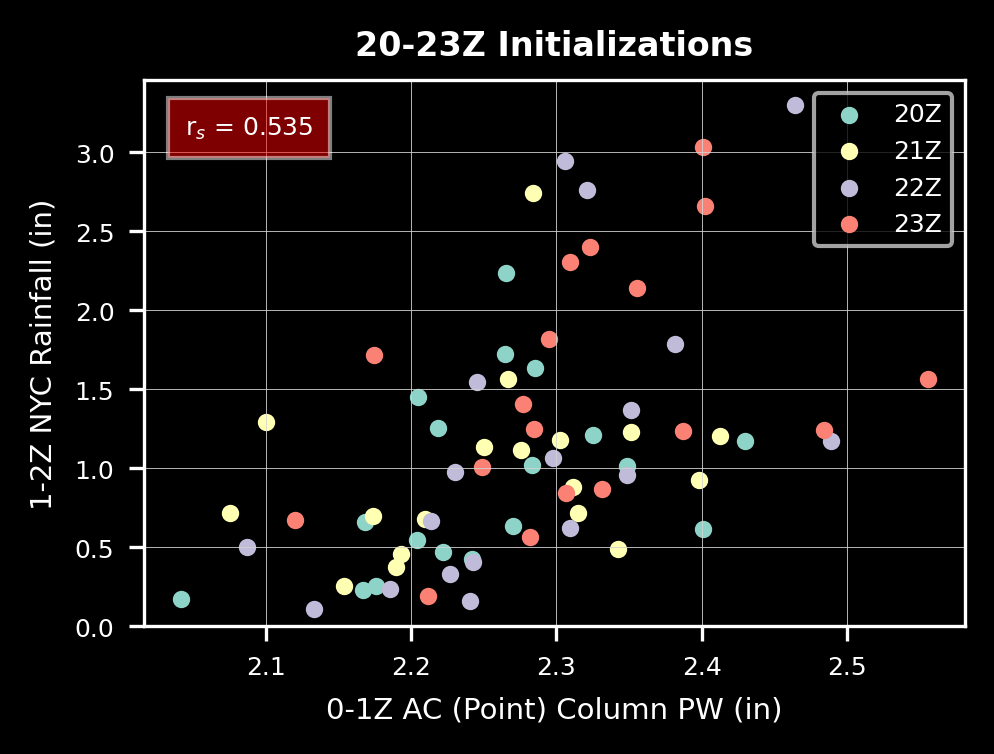

In [42]:
# Make figure
fig, ax = plt.subplots(1, 1, figsize=(3.2, 2.4), dpi=300, layout="constrained")

# Create labels
labels = ["20Z", "21Z", "22Z", "23Z"]

# Plot scatterplot
for i, l in zip(pw01_ac.init, labels):
    ax.scatter(pw01_ac.sel(init=i), rain12_nyc.sel(init=i), s=10, label=l)
ax.tick_params(axis="x", which="both", labelsize=6, labelbottom=True)
ax.tick_params(axis="y", which="both", labelsize=6, labelleft=True)
ax.grid(color="lightgray", linewidth=0.2)
ax.set_ylim(0, None)
ax.set_xlabel("0-1Z AC (Point) Column PW (in)", fontsize=7)
ax.set_ylabel("1-2Z NYC Rainfall (in)", fontsize=7)
ax.set_title("20-23Z Initializations", fontsize=8, fontweight="bold")

ax.text(
    0.05,
    0.9,
    "r$_s$ = " + str(float(corr.round(3))),  # type: ignore
    fontsize=6,
    bbox=dict(facecolor="red", alpha=0.5),
    transform=ax.transAxes,
)

ax.legend(loc="best",fontsize=6)

plt.show()